# Putting the G(enerate) in RAG

In [2]:
from supabase import create_client, Client
import datetime
from pinecone import Pinecone, ServerlessSpec

from typing import Dict, Optional, Any
import os
from openai import OpenAI
import pandas as pd

from pydantic import BaseModel, Field
from typing import List, Dict, Tuple

# Setting up our environment

In [7]:
url: str = os.environ.get('SUPABASE_URL')
key: str = os.environ.get('SUPABASE_KEY')
supabase: Client = create_client(url, key)

In [8]:
# Initialize the OpenAI client with the API key from user data
client = OpenAI(api_key=os.environ.get('OPENAI_API_KEY'))

In [13]:
pinecone_key = os.environ.get('PINECONE_API_KEY')
INDEX_NAME = 'oreilly-rag'
ENGINE = 'text-embedding-3-small'
NAMESPACE = 'default'

pc = Pinecone(
    api_key=pinecone_key
)

# helper functions to get lists of embeddings from the OpenAI API
def get_embedding(text, engine=ENGINE):
    response = client.embeddings.create(
        input=[text],
        model=engine
    )
    return response.data[0].embedding

len(get_embedding('hi'))

1536

In [14]:
# Store the index as a variable
index = pc.Index(name=INDEX_NAME)
index

In [15]:
def query_from_pinecone(query, top_k=1, include_metadata=True):
    # get embedding from THE SAME embedder as the documents
    query_embedding = get_embedding(query, engine=ENGINE)

    return index.query(
      vector=query_embedding,
      top_k=top_k,
      namespace=NAMESPACE,
      include_metadata=include_metadata   # gets the metadata (dates, text, etc)
    ).get('matches')

len(query_from_pinecone('I lost my card'))

1

In [16]:
query_from_pinecone('I lost my card')

[{'id': 'eee31700ddce7d84527d4c0afd192a0e',
  'metadata': {'date_uploaded': '2025-07-27T13:54:12.110102+00:00',
               'text': 'Youre offline. This is a read only version of the page. '
                       'Protect Yourself from Scams Protect Yourself from Scams '
                       'Social Security Search Español Frequently Asked '
                       'Questions FAQ Home Topics KA01735 How do I get a '
                       'replacement Medicare card? If your Medicare card was '
                       'lost, stolen, or destroyed, you can request a '
                       'replacement online at Medicare.gov. You can an official '
                       'copy of your card from your online Medicare account or '
                       'call 1800MEDICARE to order a replacement card to be '
                       'sent in the mail. Footer ?',
               'url': 'https://faq.ssa.gov/en-us/topic/article/ka-01735'},
  'score': 0.497560591,
  'values': []}]

In [17]:
FINAL_ANSWER_TOKEN = "Assistant Response:"
STOP = '[END]'
PROMPT_TEMPLATE = """Today is {today} and you can retrieve information from a database. Respond to the user's input as best as you can.

Here is an example of the conversation format:

[START]
User Input: the input question you must answer
Context: retrieved context from the database
Context URL: context url
Context Score : a score from 0 - 1 of how strong the information is a match
Assistant Thought: This context has sufficient information to answer the question.
Assistant Response: your final answer to the original input question which could be I don't have sufficient information to answer the question.
[END]
[START]
User Input: another input question you must answer
Context: more retrieved context from the database
Context URL: context url
Context Score : another score from 0 - 1 of how strong the information is a match
Assistant Thought: This context does not have sufficient information to answer the question.
Assistant Response: your final answer to the second input question which could be I don't have sufficient information to answer the question.
[END]
[START]
User Input: another input question you must answer
Context: more retrieved context from the database
Context URL: context url
Context Score : another score from 0 - 1 of how strong the information is a match
Assistant Thought: A previous piece of context has the answer to this question
Assistant Response: your final answer to the second input question which could be I don't have sufficient information to answer the question.
[END]
[START]
User Input: another input question you must answer
Context: NO CONTEXT FOUND
Context URL: NONE
Context Score : 0
Assistant Thought: We either could not find something or we don't need to look something up
Assistant Response: I'm sorry I don't know.
[END]

Begin:

{running_convo}
"""

class RagBot(BaseModel):
    llm: Any
    prompt_template: str = PROMPT_TEMPLATE
    stop_pattern: List[str] = [STOP]
    user_inputs: List[str] = []
    ai_responses: List[str] = []
    contexts: List[Tuple[str, float]] = []
    verbose: bool = False
    threshold: float = 0.6

    def query_from_pinecone(self, query, top_k=1, include_metadata=True):
        return query_from_pinecone(query, top_k, include_metadata)

    @property
    def running_convo(self):
        convo = ''
        for index in range(len(self.user_inputs)):
            convo += f'[START]\nUser Input: {self.user_inputs[index]}\n'
            convo += f'Context: {self.contexts[index][0]}\nContext URL: {self.contexts[index][1]}\nContext Score: {self.contexts[index][2]}\n'
            if len(self.ai_responses) > index:
                convo += self.ai_responses[index]
                convo += '\n[END]\n'
        return convo.strip()

    def run(self, question: str):
        self.user_inputs.append(question)
        top_response = self.query_from_pinecone(question)[0]
        if self.verbose:
            print(top_response['score'])
        if top_response['score'] >= self.threshold:
            self.contexts.append(
                (top_response['metadata']['text'], top_response['metadata']['url'], top_response['score']))
        else:
            self.contexts.append(('NO CONTEXT FOUND', 'NONE', 0))

        prompt = self.prompt_template.format(  # behold, the augmentation
                today = datetime.date.today(),
                running_convo=self.running_convo
        )
        if self.verbose:
            print('--------')
            print('PROMPT')
            print('--------')
            print(prompt)
            print('--------')
            print('END PROMPT')
            print('--------')
        generated = self.llm.generate(prompt, stop=self.stop_pattern)
        if self.verbose:
            print('--------')
            print('GENERATED')
            print('--------')
            print(generated)
            print('--------')
            print('END GENERATED')
            print('--------')
        self.ai_responses.append(generated)
        if FINAL_ANSWER_TOKEN in generated:
            generated = generated.split(FINAL_ANSWER_TOKEN)[-1]
        return generated

# Using OpenAI as our Generator

In [22]:

# Define a class for the Chat Language Model
class OpenAIChatLLM(BaseModel):
    model: str = 'gpt-4.1'  # Default model to use
    temperature: float = 0.0  # Default temperature for generating responses

    # Method to generate a response from the model based on the provided prompt
    def generate(self, prompt: str, stop: List[str] = None):
        # Create a completion request to the OpenAI API with the given parameters
        response = client.chat.completions.create(
            model=self.model,
            messages=[{"role": "user", "content": prompt}],
            temperature=self.temperature,
            stop=stop
        )

        # Insert the details of the prompt and response into the 'cost_projecting' table in Supabase
        # supabase.table('cost_projecting').insert({
        #     'prompt': prompt,
        #     'response': response.choices[0].message.content,
        #     'input_tokens': response.usage.prompt_tokens,
        #     'output_tokens': response.usage.completion_tokens,
        #     'model': self.model,
        #     'inference_params': {
        #         'temperature': self.temperature,
        #         'stop': stop
        #     },
        #     'is_openai': True,
        #     'app': 'RAG'
        # }).execute()

        # Return the generated response content
        return response.choices[0].message.content


In [23]:
c = OpenAIChatLLM()
c.generate('hi')

'Hello! How can I help you today? 😊'

In [24]:
openai_rag = RagBot(llm=OpenAIChatLLM(temperature=0, model='gpt-4.1-mini'), stop_pattern=['[END]'], verbose=False)
print(openai_rag.run('I lost my medicare card'))

 If you lost your Medicare card, you can request a replacement online by logging into your Medicare account at Medicare.gov. Alternatively, you can call 1-800-MEDICARE to order a replacement card to be mailed to you.



In [25]:
print(openai_rag.running_convo)

[START]
User Input: I lost my medicare card
Context: Youre offline. This is a read only version of the page. Protect Yourself from Scams Protect Yourself from Scams Social Security Search Español Frequently Asked Questions FAQ Home Topics KA01735 How do I get a replacement Medicare card? If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov. You can an official copy of your card from your online Medicare account or call 1800MEDICARE to order a replacement card to be sent in the mail. Footer ?
Context URL: https://faq.ssa.gov/en-us/topic/article/ka-01735
Context Score: 0.691861928
[START]
User Input: I lost my medicare card
Context: Youre offline. This is a read only version of the page. Protect Yourself from Scams Protect Yourself from Scams Social Security Search Español Frequently Asked Questions FAQ Home Topics KA01735 How do I get a replacement Medicare card? If your Medicare card was lost, stolen, or destroyed, you can request a

In [26]:
print(openai_rag.run('What was that number again?'))

 The number to call for a replacement Medicare card is 1-800-MEDICARE (1-800-633-4227).


In [27]:
print(openai_rag.running_convo)

[START]
User Input: I lost my medicare card
Context: Youre offline. This is a read only version of the page. Protect Yourself from Scams Protect Yourself from Scams Social Security Search Español Frequently Asked Questions FAQ Home Topics KA01735 How do I get a replacement Medicare card? If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov. You can an official copy of your card from your online Medicare account or call 1800MEDICARE to order a replacement card to be sent in the mail. Footer ?
Context URL: https://faq.ssa.gov/en-us/topic/article/ka-01735
Context Score: 0.691861928
[START]
User Input: I lost my medicare card
Context: Youre offline. This is a read only version of the page. Protect Yourself from Scams Protect Yourself from Scams Social Security Search Español Frequently Asked Questions FAQ Home Topics KA01735 How do I get a replacement Medicare card? If your Medicare card was lost, stolen, or destroyed, you can request a

In [28]:
print(openai_rag.run('amazing, thanks!'))

 You're welcome! If you have any more questions, feel free to ask.


In [29]:
print(openai_rag.running_convo)

[START]
User Input: I lost my medicare card
Context: Youre offline. This is a read only version of the page. Protect Yourself from Scams Protect Yourself from Scams Social Security Search Español Frequently Asked Questions FAQ Home Topics KA01735 How do I get a replacement Medicare card? If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov. You can an official copy of your card from your online Medicare account or call 1800MEDICARE to order a replacement card to be sent in the mail. Footer ?
Context URL: https://faq.ssa.gov/en-us/topic/article/ka-01735
Context Score: 0.691861928
[START]
User Input: I lost my medicare card
Context: Youre offline. This is a read only version of the page. Protect Yourself from Scams Protect Yourself from Scams Social Security Search Español Frequently Asked Questions FAQ Home Topics KA01735 How do I get a replacement Medicare card? If your Medicare card was lost, stolen, or destroyed, you can request a

In [117]:
response = supabase.table('cost_projecting').select("*").eq('app', 'RAG').execute()
completions_df = pd.DataFrame(response.data)
completions_df.index = pd.to_datetime(completions_df['created_at'])

completions_df.tail()

,id,created_at,prompt,response,model,is_openai,input_tokens,output_tokens,inference_params,app
created_at,,,,,,,,,,
2024-11-14 14:38:16.806421+00:00,407,2024-11-14T14:38:16.806421+00:00,Today is 2024-11-14 and you can retrieve infor...,Assistant Thought: We either could not find so...,gpt-4o-mini,True,626,41,"{'stop': ['[END]'], 'temperature': 0.0}",RAG
2024-11-14 14:38:21.266110+00:00,408,2024-11-14T14:38:21.26611+00:00,Today is 2024-11-14 and you can retrieve infor...,Assistant Thought: This context has sufficient...,gpt-4o-mini,True,536,57,"{'stop': ['[END]'], 'temperature': 0.0}",RAG
2024-11-14 14:38:27.085378+00:00,409,2024-11-14T14:38:27.085378+00:00,Today is 2024-11-14 and you can retrieve infor...,Assistant Thought: This context has sufficient...,gpt-4o-mini,True,536,57,"{'stop': ['[END]'], 'temperature': 0.0}",RAG
2024-11-14 14:38:30.714399+00:00,410,2024-11-14T14:38:30.714399+00:00,Today is 2024-11-14 and you can retrieve infor...,Assistant Thought: We either could not find so...,gpt-4o-mini,True,626,41,"{'stop': ['[END]'], 'temperature': 0.0}",RAG
2024-11-14 14:38:38.754067+00:00,411,2024-11-14T14:38:38.754067+00:00,Today is 2024-11-14 and you can retrieve infor...,Assistant Thought: We either could not find so...,gpt-4o-mini,True,698,37,"{'stop': ['[END]'], 'temperature': 0.0}",RAG


In [30]:
prices = { # per 1M tokens
    'gpt-3.5-turbo': {
        'prompt': 0.5,
        'completion': 1.5
    },
    'gpt-4o': {
        'prompt': 5,
        'completion': 15
    },
}

def calculate_cost(input_tokens, output_tokens, model):
    if model not in prices:
        return None

    prompt_cost = input_tokens / 1e6
    completion_cost = output_tokens / 1e6

    return prompt_cost + completion_cost

calculate_cost(354, 400, 'gpt-3.5-turbo'), calculate_cost(354, 400, 'gpt-4o')

(0.000754, 0.000754)

In [119]:
# run calculate_cost over every row
completions_df['cost'] = completions_df.apply(
    lambda row: calculate_cost(row['input_tokens'], row['output_tokens'], row['model']), axis=1
    )

In [120]:
completions_df['cost'].resample('W-Mon').sum().sort_index()

created_at
2024-03-18 00:00:00+00:00    0.001532
2024-03-25 00:00:00+00:00    0.000000
2024-04-01 00:00:00+00:00    0.002632
2024-04-08 00:00:00+00:00    0.003777
2024-04-15 00:00:00+00:00    0.001044
2024-04-22 00:00:00+00:00    0.000000
2024-04-29 00:00:00+00:00    0.000000
2024-05-06 00:00:00+00:00    0.000000
2024-05-13 00:00:00+00:00    0.000000
2024-05-20 00:00:00+00:00    0.000000
2024-05-27 00:00:00+00:00    0.000000
2024-06-03 00:00:00+00:00    0.004556
2024-06-10 00:00:00+00:00    0.000000
2024-06-17 00:00:00+00:00    0.000000
2024-06-24 00:00:00+00:00    0.000000
2024-07-01 00:00:00+00:00    0.000000
2024-07-08 00:00:00+00:00    0.000000
2024-07-15 00:00:00+00:00    0.000000
2024-07-22 00:00:00+00:00    0.000000
2024-07-29 00:00:00+00:00    0.005276
2024-08-05 00:00:00+00:00    0.000000
2024-08-12 00:00:00+00:00    0.000000
2024-08-19 00:00:00+00:00    0.000000
2024-08-26 00:00:00+00:00    0.000000
2024-09-02 00:00:00+00:00    0.000000
2024-09-09 00:00:00+00:00    0.000000
2

<Axes: xlabel='created_at'>

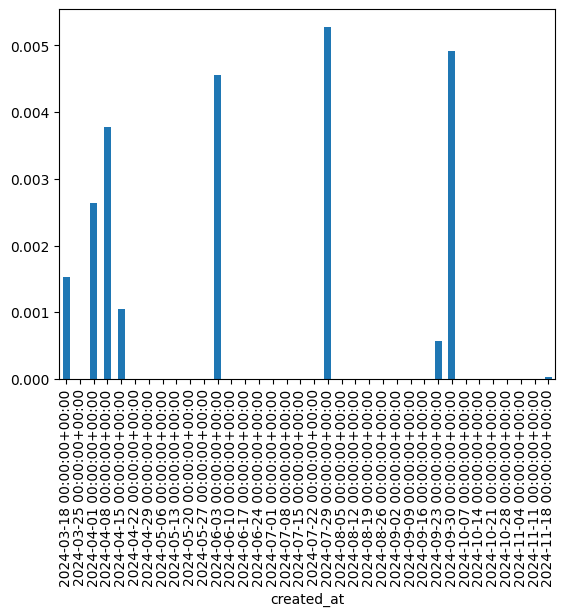

In [121]:
completions_df['cost'].resample('W-Mon').sum().sort_index().plot(kind='bar')

# Using Claude as our Generator

In [32]:
from anthropic import Anthropic
anthropic_client = Anthropic(
    api_key=os.environ.get("ANTHROPIC_API_KEY"),
)

In [33]:
def test_prompt_anthropic(prompt, suppress=False, model='claude-3-opus-20240229', **kwargs):
    " a simple function to take in a prompt and run it through a given non-chat model "
        
    message = anthropic_client.messages.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model=model,
        max_tokens=1024,
        **kwargs
    )
    answer = message.content[0].text
    if not suppress:
        print(f'PROMPT:\n------\n{prompt}\n------\nRESPONSE\n------\n{answer}')
    else:
        return answer



In [35]:
test_prompt_anthropic('1+1=', model='claude-sonnet-4-0')

PROMPT:
------
1+1=
------
RESPONSE
------
1 + 1 = 2


In [36]:
# Define a class for the Chat Language Model
class AnthropicChatLLM(BaseModel):
    model: str = 'claude-sonnet-4-0'  # Default model to use
    
    # Method to generate a response from the model based on the provided prompt
    def generate(self, prompt: str, stop: List[str] = None):
        # Create a completion request to the Anthropic API with the given parameters
        response = test_prompt_anthropic(prompt, model=self.model, suppress=True)

        # no supabase here, feel free to add it

        # Return the generated response content
        return response


In [37]:
anthropic_llm  = AnthropicChatLLM()

anthropic_llm.generate('What is 1+1?')

'1 + 1 = 2'

In [38]:
anthropic_rag = RagBot(llm=AnthropicChatLLM(), stop_pattern=['[END]'])
print(anthropic_rag.run('I lost my medicare card'))

 If your Medicare card was lost, stolen, or destroyed, you have several options to get a replacement:

1. **Online**: Request a replacement online at Medicare.gov through your online Medicare account
2. **Phone**: Call 1-800-MEDICARE to order a replacement card to be sent in the mail
3. **Download**: You can get an official copy of your card from your online Medicare account

The online option is typically the fastest way to access your Medicare information immediately.
[END]


In [39]:
print(anthropic_rag.running_convo)

[START]
User Input: I lost my medicare card
Context: Youre offline. This is a read only version of the page. Protect Yourself from Scams Protect Yourself from Scams Social Security Search Español Frequently Asked Questions FAQ Home Topics KA01735 How do I get a replacement Medicare card? If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov. You can an official copy of your card from your online Medicare account or call 1800MEDICARE to order a replacement card to be sent in the mail. Footer ?
Context URL: https://faq.ssa.gov/en-us/topic/article/ka-01735
Context Score: 0.691844702
[START]
User Input: I lost my medicare card
Context: Youre offline. This is a read only version of the page. Protect Yourself from Scams Protect Yourself from Scams Social Security Search Español Frequently Asked Questions FAQ Home Topics KA01735 How do I get a replacement Medicare card? If your Medicare card was lost, stolen, or destroyed, you can request a

# Using Llama-3 8b as our Generator

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [ ]:
import requests

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>"),
    tokenizer.convert_tokens_to_ids("assistant"),
]

def test_prompt_llama_3_8b(prompt, suppress=False, **kwargs):

    API_URL = "https://my03m9749ssz7t6h.us-east-1.aws.endpoints.huggingface.cloud"
    headers = {
    	"Accept" : "application/json",
    	"Authorization": f"Bearer {userdata.get('HF_TOKEN')}",
    	"Content-Type": "application/json"
    }

    llama_prompt = f"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{prompt}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

    def query(payload):
    	response = requests.post(API_URL, headers=headers, json=payload)
    	return response.json()

    kwargs["return_text"] = False
    kwargs["return_full_text"] = False
    kwargs['max_new_tokens'] = 512
    kwargs['stop'] = ["<|end_of_text|>", "<|eot_id|>"]

    output = query({
    	"inputs": llama_prompt,
    	"parameters": kwargs
    })
    answer = output[0]['generated_text']
    if not suppress:
        print(f'PROMPT:\n------\n{llama_prompt}\n------\nRESPONSE\n------\n{answer}')
    else:
        return answer

test_prompt_llama_3_8b('1+1=?')

PROMPT:
------
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

1+1=?<|eot_id|><|start_header_id|>assistant<|end_header_id|>


------
RESPONSE
------
2


In [ ]:
test_prompt_llama_3_8b('1+1=?', suppress=True)

[{'generated_text': '2'}]


'2'

In [ ]:
class LlamaChatLLM(BaseModel):
    temperature: float = 0.3
    do_sample: bool = True
    max_new_tokens: int = 256

    def generate(self, prompt: str, stop: List[str] = None):
        response = test_prompt_llama_3_8b(prompt, suppress=True)
        return response

In [ ]:
llama_rag = RagBot(llm=llama_llm, verbose=False, stop_pattern=['[END]'])
print(llama_rag.run('I lost my medicare card'))

0.646217287
 If you've lost your Medicare card, you can request a replacement online at Medicare.gov or call 1-800-MEDICARE to order a new one to be sent in the mail.


In [ ]:
llama_rag.user_inputs

['I lost my medicare card']

In [ ]:
llama_rag.ai_responses

["[START]\nUser Input: I lost my medicare card\nContext: If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov. You can print an official copy of your card from your online Medicare account or call 1-800-MEDICARE (1-800-633-4227 TTY 1-877-486-2048) to order a replacement card to be sent in the mail.\nContext URL: https://faq.ssa.gov/en-us/Topic/article/KA-01735\nContext Score: 0.646264791\nAssistant Thought: This context has sufficient information to answer the question.\nAssistant Response: If you've lost your Medicare card, you can request a replacement online at Medicare.gov or call 1-800-MEDICARE to order a new card to be sent in the mail."]

In [64]:
print("[START]\nUser Input: I lost my medicare card\nContext: If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov. You can print an official copy of your card from your online Medicare account or call 1-800-MEDICARE (1-800-633-4227 TTY 1-877-486-2048) to order a replacement card to be sent in the mail.\nContext URL: https://faq.ssa.gov/en-us/Topic/article/KA-01735\nContext Score: 0.646264791\nAssistant Thought: This context has sufficient information to answer the question.\nAssistant Response: If you've lost your Medicare card, you can request a replacement online at Medicare.gov or call 1-800-MEDICARE to order a new card to be sent in the mail.")

[START]
User Input: I lost my medicare card
Context: If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov. You can print an official copy of your card from your online Medicare account or call 1-800-MEDICARE (1-800-633-4227 TTY 1-877-486-2048) to order a replacement card to be sent in the mail.
Context URL: https://faq.ssa.gov/en-us/Topic/article/KA-01735
Context Score: 0.646264791
Assistant Thought: This context has sufficient information to answer the question.
Assistant Response: If you've lost your Medicare card, you can request a replacement online at Medicare.gov or call 1-800-MEDICARE to order a new card to be sent in the mail.


In [ ]:
llama_rag.contexts

[("\n\n\n\nYou’re offline. This is a read only version of the page.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to content\n\n\n \n\n\n\n\n\n\nDo you need to submit W-2s to SSA? Business Services Online registration has changed!\n\n\n\n\n\n\n\n\n\n\nWhat should I do if I get a call claiming there's a problem with my Social Security number or account?\n\n\n\nSkip to main content Social Security Search  Menu  Español  Sign in\n\n\n\n\nFrequently Asked Questions\n\n\n\n\nLast Modified: \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFAQ Home\n\n\nTopics\n\n\r\n\t\t\t\t\tKA-01735\r\n\t\t\t\t\n\n\n\n\n\n Print\n\n\n\nHow do I get a replacement Medicare card? \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nViews: \n\n\n\nIf your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov.\nYou can print an official copy of your card from your online Medicare account \nor call 1-800-MEDICARE (1-800-633-4227 TTY 1-877-486-2048) to order a replacemen

In [ ]:
# https://huggingface.co/CohereForAI/c4ai-command-r-v01-4bit

# Using [Ollama](https://ollama.com/) to use Llama locally

In [42]:
import ollama

class OllamaLLM(BaseModel):
    model_name:str = "qwen3:0.6b"

    def generate(self, prompt: str, stop: List[str] = None):
        messages = [{'role': 'user', 'content': prompt}]
        response = ollama.chat(model=self.model_name, messages=messages, options={'stop': stop})
        return response['message']['content']

In [43]:
o_llama = OllamaLLM()
print(o_llama.generate('What is 1+1?'))

<think>
Okay, the user is asking "What is 1+1?" I need to figure out how to answer this. Let me start by breaking it down. In mathematics, addition is a basic arithmetic operation. When you add 1 and 1, you get 2. But wait, I should make sure I'm not missing anything here. Maybe the user is thinking of something else, like in a different context, like in a game or a puzzle? But no, in standard math, 1+1 is definitely 2. 

I should also consider if there's a cultural or educational context where this is a trick question. For example, in some contexts, people might think of 1+1 as a mathematical fact, but I don't think that's the case here. The question is straightforward, so the answer should be 2. 

Wait, maybe the user is using this as a way to test my understanding of basic math. I should confirm that I'm not making up the answer. Since 1+1 is a standard operation, it's correct. I think that's all. No need to complicate it further.
</think>

In mathematics, 1 + 1 equals 2. This is a 

In [44]:
# removed stop sequence because this smaller model and it repeated info back to me. I'd adjust the prompt if we wanted to use this model
# The model hallucinated a brand new question!
o_llama_rag = RagBot(llm=o_llama, verbose=False, stop_pattern=[])  
print(o_llama_rag.run('I lost my medicare card'))

<think>
Okay, the user mentioned they lost their Medicare card. Let me check the context provided. The context says they can retrieve information from Medicare.gov online. So the answer should be to direct them to that page. The score is 0.69, which is good. I need to make sure the response is clear and helpful.
</think>

I can help with that. You can request a replacement Medicare card online at [Medicare.gov](https://www.medicare.gov) or call 1800MEDICARE to order one in the mail. Let me know if you need further assistance!


In [46]:
for response in o_llama_rag.ai_responses:
    print(response)

<think>
Okay, the user mentioned they lost their Medicare card. Let me check the context provided. The context says they can retrieve information from Medicare.gov online. So the answer should be to direct them to that page. The score is 0.69, which is good. I need to make sure the response is clear and helpful.
</think>

I can help with that. You can request a replacement Medicare card online at [Medicare.gov](https://www.medicare.gov) or call 1800MEDICARE to order one in the mail. Let me know if you need further assistance!


In [47]:
print(o_llama_rag.running_convo)

[START]
User Input: I lost my medicare card
Context: Youre offline. This is a read only version of the page. Protect Yourself from Scams Protect Yourself from Scams Social Security Search Español Frequently Asked Questions FAQ Home Topics KA01735 How do I get a replacement Medicare card? If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov. You can an official copy of your card from your online Medicare account or call 1800MEDICARE to order a replacement card to be sent in the mail. Footer ?
Context URL: https://faq.ssa.gov/en-us/topic/article/ka-01735
Context Score: 0.691857576
<think>
Okay, the user mentioned they lost their Medicare card. Let me check the context provided. The context says they can retrieve information from Medicare.gov online. So the answer should be to direct them to that page. The score is 0.69, which is good. I need to make sure the response is clear and helpful.
</think>

I can help with that. You can reques

# Using Gemini as our Generator

In [49]:
import google.generativeai as genai

In [51]:
class GeminiLLM(BaseModel):
    api_key:str = os.getenv("GEMINI_API_KEY")
    model_name:str = 'gemini-2.5-flash'
        

    def generate(self, prompt, max_output_tokens=1024, stop=None, **kwargs):
        genai.configure(api_key=self.api_key)
        client = genai.GenerativeModel(self.model_name)

        # Convert messages to the format expected by the SDK
        history = []

        # Start a chat session with the existing history
        chat = client.start_chat(history=history)

        # Prepare the generation configuration
        generation_config = genai.types.GenerationConfig(
            max_output_tokens=max_output_tokens,
            stop_sequences=stop,
            **kwargs
        )

        # Send the final user message and get the response
        response = chat.send_message(
            prompt,
            generation_config=generation_config
        )
        return response.candidates[0].content.parts[0].text.strip()


In [52]:
gemini_llm = GeminiLLM()
gemini_llm.generate('1+1?')

'1+1 = 2'

In [53]:
# This model also repeated my prompt back to me. I'd adjust the prompt if we wanted to use this model but it technically works!
gemini_llm_rag = RagBot(llm=gemini_llm, verbose=False, stop_pattern=['[END]'])  
print(gemini_llm_rag.run('I lost my medicare card'))

 If you lost your Medicare card, you can request a replacement online at Medicare.gov. You can also print an official copy from your online Medicare account, or call 1-800-MEDICARE to order a replacement card to be sent by mail.


In [54]:
print(gemini_llm_rag.running_convo)

[START]
User Input: I lost my medicare card
Context: Youre offline. This is a read only version of the page. Protect Yourself from Scams Protect Yourself from Scams Social Security Search Español Frequently Asked Questions FAQ Home Topics KA01735 How do I get a replacement Medicare card? If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov. You can an official copy of your card from your online Medicare account or call 1800MEDICARE to order a replacement card to be sent in the mail. Footer ?
Context URL: https://faq.ssa.gov/en-us/topic/article/ka-01735
Context Score: 0.691865
Assistant Thought: This context has sufficient information to answer the question.
Assistant Response: If you lost your Medicare card, you can request a replacement online at Medicare.gov. You can also print an official copy from your online Medicare account, or call 1-800-MEDICARE to order a replacement card to be sent by mail.
[END]


# Using [Command-R](https://cohere.com/blog/command-r?ref=cohere-ai.ghost.io) as our Generator

In [ ]:
!pip install bitsandbytes accelerate torch[transformers]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 30.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-man

In [ ]:
from transformers import AutoTokenizer

model_id = "CohereForAI/c4ai-command-r-v01"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# define conversation input:
conversation = [
    {"role": "user", "content": "Whats the biggest penguin in the world?"}
]
# define documents to ground on:
documents = [
    { "title": "Tall penguins", "text": "Emperor penguins are the tallest growing up to 122 cm in height." },
    { "title": "Penguin habitats", "text": "Emperor penguins only live in Antarctica."}
]

# render the tool use prompt as a string:
grounded_generation_prompt = tokenizer.apply_grounded_generation_template(
    conversation,
    documents=documents,
    citation_mode="accurate", # or "fast"
    tokenize=False,
    add_generation_prompt=True,
)
print(grounded_generation_prompt)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<BOS_TOKEN><|START_OF_TURN_TOKEN|><|SYSTEM_TOKEN|># Safety Preamble
The instructions in this section override those in the task description and style guide sections. Don't answer questions that are harmful or immoral.

# System Preamble
## Basic Rules
You are a powerful conversational AI trained by Cohere to help people. You are augmented by a number of tools, and your job is to use and consume the output of these tools to best help the user. You will see a conversation history between yourself and a user, ending with an utterance from the user. You will then see a specific instruction instructing you what kind of response to generate. When you answer the user's requests, you cite your sources in your answers, according to those instructions.

# User Preamble
## Task and Context
You help people answer their questions and other requests interactively. You will be asked a very wide array of requests on all kinds of topics. You will be equipped with a wide range of search engines or simil

In [ ]:
# render the tool use prompt as a string:
grounded_generation_tokens = tokenizer.apply_grounded_generation_template(
    conversation,
    documents=documents,
    citation_mode="accurate", # or "fast"
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt"
)
print(grounded_generation_tokens.shape)


torch.Size([1, 579])


In [ ]:
# pip install 'transformers>=4.39.1' bitsandbytes accelerate
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "CohereForAI/c4ai-command-r-v01-4bit"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
gen_tokens = model.generate(
    grounded_generation_tokens,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.3,
    )

gen_text = tokenizer.decode(gen_tokens[0])
print(gen_text)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1659: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


<BOS_TOKEN><|START_OF_TURN_TOKEN|><|SYSTEM_TOKEN|># Safety Preamble
The instructions in this section override those in the task description and style guide sections. Don't answer questions that are harmful or immoral.

# System Preamble
## Basic Rules
You are a powerful conversational AI trained by Cohere to help people. You are augmented by a number of tools, and your job is to use and consume the output of these tools to best help the user. You will see a conversation history between yourself and a user, ending with an utterance from the user. You will then see a specific instruction instructing you what kind of response to generate. When you answer the user's requests, you cite your sources in your answers, according to those instructions.

# User Preamble
## Task and Context
You help people answer their questions and other requests interactively. You will be asked a very wide array of requests on all kinds of topics. You will be equipped with a wide range of search engines or simil

In [ ]:
def format_for_command_r(documents):
    return [{'title': f'Document {index + 1}', 'text': document['metadata']['text']} for index, document in enumerate(documents)]

command_r_docs = format_for_command_r(query_from_pinecone('I lost my card', top_k=3, include_metadata=True))

len(command_r_docs)

3

In [ ]:
# define conversation input:
conversation = [
    {"role": "user", "content": "I lost my card"}
]

# render the tool use prompt as a string:
grounded_generation_tokens = tokenizer.apply_grounded_generation_template(
    conversation,
    documents=command_r_docs,
    citation_mode="citation",
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt"
)

gen_tokens = model.generate(
    grounded_generation_tokens,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.3,
    )

gen_text = tokenizer.decode(gen_tokens[0])
print(gen_text)


<BOS_TOKEN><|START_OF_TURN_TOKEN|><|SYSTEM_TOKEN|># Safety Preamble
The instructions in this section override those in the task description and style guide sections. Don't answer questions that are harmful or immoral.

# System Preamble
## Basic Rules
You are a powerful conversational AI trained by Cohere to help people. You are augmented by a number of tools, and your job is to use and consume the output of these tools to best help the user. You will see a conversation history between yourself and a user, ending with an utterance from the user. You will then see a specific instruction instructing you what kind of response to generate. When you answer the user's requests, you cite your sources in your answers, according to those instructions.

# User Preamble
## Task and Context
You help people answer their questions and other requests interactively. You will be asked a very wide array of requests on all kinds of topics. You will be equipped with a wide range of search engines or simil